# P5: Neural Networks and Automatic Differentiation
## Due date: 16 Dec at 23:59
## Total Points: 22

For this assignment we will implement a basic neural network. The notation used for this in *Alpaydin* is good to help you understand the correlation between a single perceptron and linear discrimination functions, and to understand the derivatives that are the basis for backpropagation in a neural network. However, it does not contain enough information to actually build a complete multilayer perceptron.

For this we will use a different notation, also used by *Andrew Ng* in his videos. The benefit of this notation is that it is complete, and thus translating it to data operations for the implementation is relatively straightforward. Also the notation lends itself well to using matrix multiplications, meaning a lot of the operations can actually be simplified to a couple of efficient steps.

This does however mean it might take some figuring out how to map the equations from *Alpaydin* to the equations here. Mostly this will just be separating the steps in a different way and using different indices, but as stated, this will make implementing a lot easier. Plus, neural networks can be somewhat unintuitive in the beginning, so having another perspective might help make things click in your own (biological) neural network. To aid you during your work, we have written a small set of tests (in the form of assertions) that should show you wether your solution is working as intended.

## Perceptron / Logistic Regression

Lets start by zooming in on the parameters for just one node in the *Neural Network*.

There are many different types of activation function you can use in a *Neural Network*, but the *Sigmoid* (a.k.a. *logistic*) activation function is the classic and most common type. If you use this activation function for a single node perceptron, the combined equations will correspond exactly with the *Logistic Regression* model from Chapter 10.

Watch these 2 videos for the idea behind *Logistic Regression* for classification or why the *Sigmoid* function is used for this.

Learning a classification function


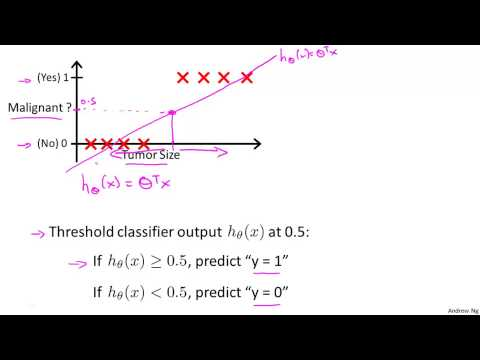

Learning a classification function


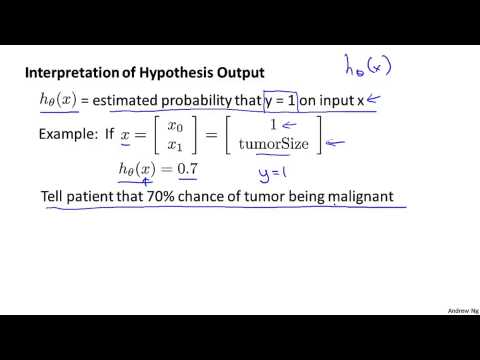

In [1]:
from IPython.display import YouTubeVideo

print('Learning a classification function')
display(YouTubeVideo('K5oZM1Izn3c'))

print('Learning a classification function')
display(YouTubeVideo('WiDuvuM1JyI'))

### Sigmoid Function [1 pt]

The sigmoid (a.k.a. logistic) function is defined as:

$$g(x) = \frac{1}{1 + e^{-x}} $$

Write the function `sigmoid` that can either take a single value `X`, or an array of values `X`, and compute the *Sigmoid* function for each.  

Below, we're going to import `numpy` a slightly different way.  We are going to import it from the library [Jax](https://github.com/google/jax).  Note that you'll (probably) see the warning: `WARNING:absl:No GPU/TPU found, falling back to CPU.`  This is expected, as it just means that the operations will be run on the CPU instead of a GPU (which would be faster, but performance shouldn't be a problem for this exercise).  

*Hint: Numpy built-in functions and basic arithmetic operations work on both Numpy arrays and single values.*

In [2]:
# We going to import numpy slightly differently, from the jax library.  
# The reason for the change will be obvious later in the assignment
import jax.numpy as np
from jax import random

def sigmoid(X):
    # X: scalar, vector, or matrix
    # return: element-wise application of sigmoid function
    ### YOUR SOLUTION HERE

    return 1 / (1 + np.exp(-X))

assert sigmoid(0) == 0.5
assert sigmoid(1) == np.e / (1 + np.e)
assert np.allclose(sigmoid(np.array([0,1])), np.array([0.5, np.e / (1 + np.e)]))

### Adding a bias node  [1 pt]

The model for *Logistic Regression* as given by *Alpaydin* is

(10.37) $$y^t = \frac{1}{1 + e^{-(w^T x^t + w_0 )}}$$

This model can compute every $y^t$ value for a some matrix of $X$ values, however, as you might have noticed in the *Logistic Regression* video, there is an alternative. If we expand the matrix $X$ with a column that holds $1$ values used for the bias inputs, just like with the *Polynomial Regression* $D$ matrix, then the equation simplifies to:

$$y^t = \frac{1}{1 + e^{-w^T x^t}}$$

By redefining $x = [1, x^T]^T = [1, x_1, x_2, \ldots, x_d]^T$ and $w = [1, w^T]^T = [w_0, w_1, w_2, \ldots, w_d]^T$

And the model for a single perceptron node (assuming 3 input variables) now becomes:

<img src="https://raw.githubusercontent.com/enalisnick/paper_summaries/master/NN_percep.png" width="40%">

Note that given some vector of weights $w$ and a matrix of inputs $X$, computing $w^T x^t$ for **all** of the $X$ rows just becomes a single matrix multiplication. Given that your `sigmoid` function can also handle array inputs, transforming this array into an array of *Sigmoid* function outputs should also just be a single function call. Doing each of the steps of the computation efficiently is a key component is building a *Neural Network*.

Write the function `add_bias`, which takes a matrix of `X` values, and returns that same matrix with a column of ones added to the front. Take a look at [`np.concatenate`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.concatenate.html).

In [3]:
def add_bias(X):
    # X: NxD matrix of features or activation values
    # return: X with an additional column of ones (prepended)
    ### YOUR SOLUTION HERE
    N = X.shape[0]
    ones = np.ones((N, 1))
    return np.concatenate((ones, X), axis=1)

assert np.allclose(add_bias(np.array([[0],[1],[2],[3]])), np.array([[1,0],[1,1],[1,2],[1,3]]))

## Expanding to a single layer of nodes

Until now we have only considered individual node outputs $y^t$, but *Neural Networks* are built from layers of these nodes. Each of these layers consists of a combination of one or more *Sigmoid* nodes. Using multiple nodes on the output layer, it is possible to classify multiple classes, instead of just using $0$ and $1$ outputs on a single node. See the video below for a brief example.

Multiclass classification


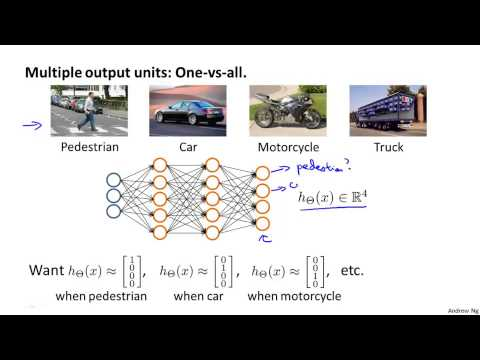

In [4]:
print('Multiclass classification')
display(YouTubeVideo('HzpptanxP6A'))

As each of the these *Sigmoid* nodes will need a set of weights based on their inputs, the weights for a single layer will now be a matrix of shape $(n, m + 1)$; for each node $n$, there are $m + 1$ inputs ($m$ inputs and the bias node).  This matrix will be called $\Theta$, where each row contains the weights for one of the sigmoid nodes. We will start with only a single layer network, but in a complete network this matrix is indexed as follows,

$$\Theta^j_{ki}$$

which is **the weight from $i^{th}$ node in layer $j$ to the $k^{th}$ node in layer $j+1$**. *Note: this indexing might seems counterintuitive, but is convention for a reason, as we will see later.* 

For now, we will only build a single layer network, which means we will only need to define $\Theta^0$. Consider the example single layer network below:

 <img src="https://raw.githubusercontent.com/enalisnick/paper_summaries/master/NN_single.png" width="40%">
 
It has 3 input nodes (+1 bias node) and 3 output nodes, meaning it can learn to distinguish 3 classes based on the value of 3 input variables. The matrix $\Theta^0$ would describe all the weights between the layer 0 nodes and the layer 1 nodes, and thus has dimension $3x4$. For example, $\Theta^0_{03}$ would describe the weight from node 3 in layer 0 (which is $x_3$) to node 0 in layer 1 (which is $A^1_0$).

### Initializing weights

Even if we don't exactly know yet how to compute the corresponding output values, lets start by creating a matrix of the correct dimensions to hold the $\Theta^0$ weights. When creating a *Neural Network*, it important to use random starting values for the weights. This has to do with the fact that we will again use partial derivative to find the optimal values for the model parameters, and want different derivative values for different nodes. For more context on why this useful, you can watch:

Random initialization


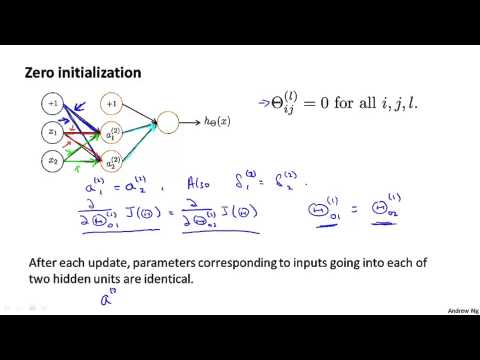

In [5]:
print('Random initialization')
display(YouTubeVideo('NhgB6FLyHJc'))

For now, lets just create a matrix with some random starting values for $\Theta^0$, so we can begin computing outputs for the first layer of the network. Below I have already provided the `one_layer_init` function for you.  It takes the number of input and output nodes and returns a matrix of weights of the correct dimensions.  Note that the bias is accounted for by using `input_size + 1`. Each weight should be randomly initialized using a uniform distribution over the range $[-3, +3]$.

In [6]:
# Code for initializing parameters (weights)
# I provide it for you since, when using jax's numpy,
# random variables are sampled slightly differently.
# Specifically, we need to pass a random seed, which
# is the `jax_key` variable below.

jax_key = random.PRNGKey(0)

def one_layer_init(input_size, output_size):
    # Note: input_size does not count the bias (so we add one below)
    return random.uniform(key=jax_key, shape=(output_size, input_size + 1), minval=-3, maxval=3)

## Multilayer Perceptron / Neural Network

Now lets start combining these pieces and work on the actual *Neural Network* computation model. **This model will not be able to "learn" just yet, only compute outputs given some inputs and a matrix of weights.**

Hopefully you already have a bit of an idea of what this would look like for a 1 layer network, but here we will build the complete multilayer version, in order to get some sense of the final picture too. Watch these 2 videos on the model representation:

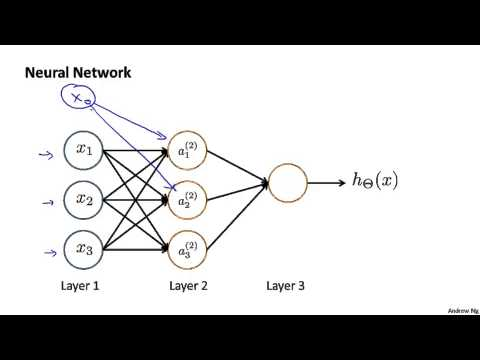

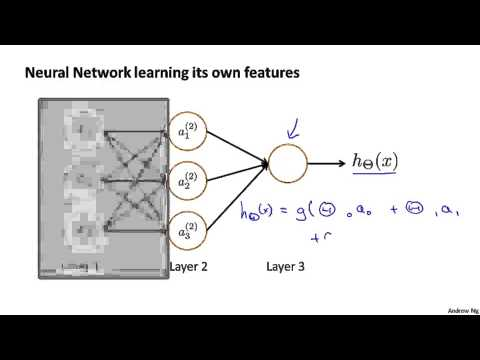

In [7]:
display(YouTubeVideo('wnSol2JRZeY'))
display(YouTubeVideo('vuhueI_7324'))

So, for the multilayer case, the outputs from one layer just become the inputs for the next layer. Completing the system of equations; the activation at the input layer consists of the bias term and the values for each of the input variables.

$$A^0 = [1, x_1, x_2 \dots x_d]$$

The combined input for each next node in the layer j+1 is just the sum of the activations from the previous layer multiplied by their respective weights:

$$Z^{j+1}_k = \sum_i A^j_i\Theta^j_{ki}$$

And then the activation for each of these nodes is computed by simply taking the *Sigmoid* function of the combined node input:

$$A^j_i = g(Z^j_i)$$

which can then again be used as input for the next layer of nodes, until the output layer is reached.

Expanding the single layer example from earlier to a 2 layer network with 1 output node, would look like:

 <img src="https://raw.githubusercontent.com/enalisnick/paper_summaries/master/NN_multi.png" width="60%">
 
This example now has 3 input nodes (+1 bias node), 3 hidden nodes (+1 bias node) and 1 output node.

An important thing to note is that all these equations are for a single row of input values $x^t$, so they just compute the output for a single sample in the data, whatever the dimensions and weights of the network actually are. In order to make your code more efficient, you should write all these functions to compute their steps on the entire data matrix $X$. In essence that just means repeating the equations for each of $M$ rows in the data set, but in practice it can often be written as some matrix multiplication. This does not only apply to the functions directly below, but to all of the following functions in the assignment. The code to write the functions as matrix operations is actually shorter and more efficient, so take the time to think about if you could avoid writing loops in your code. Drawing the dimensions of the matrices might help with this.

### Computing activations for one layer [1 pt]
We will start by implementing the functions that would be required to compute the activations for a single layer. This includes the calculation of activations of the layer, and the output calculation. For the required equations, refer to the text directly above.

Write a general function `compute_layer`, which takes a matrix for $A^j$ values, where each row represents the activations of the nodes for a different data sample, and matrix $\Theta^j$, defining the connection weights for that layer, and return next the matrix $A^{j+1}$. Try and write this operation as matrix multiplication and remember that you already wrote your *Sigmoid* function (`sigmoid`) to also work on Numpy arrays.

In [8]:
def compute_layer(A_j, Theta_j):
    # A_j: previous layer's activation values
    # Theta_j: weight / param matrix of size (n_output x n_input)
    # return: next layer's activation values
    ### YOUR SOLUTION HERE
    return sigmoid(A_j @ Theta_j.T)

assert np.allclose(compute_layer(np.array([[1,0]]), np.array([[1,2],[0.5,0]])), np.array([[np.e / (1 + np.e), np.e**0.5 / (1 + np.e**0.5)]]))

### Multilayer initialization and forward computation [2 pts]

In order to work with multilayer networks, we will need to initialize several weight matrices.  Let's write a function for that below: `n_layer_init` should take as input a tuple or list named `layer_sizes`.  `layer_sizes` should contain the size of every layer (including the input and output ones).  For instance, for a perceptron / logistic regression with 5 inputs and 1 output, `layer_sizes = [5, 1]`.  For a network with one hidden layer of 10 units, we'd have `layer_sizes = [5, 10, 1]` (using the same input / output sizes). `n_layer_init` should then return a **list** of randomly initialized weight matrices of the correct dimensions to connect each of the layers. Be sure to use the `one_layer_init` function defined above to obtain the random intitializations.

In [9]:
from random import randint

def initialize_matrix(size1, size2):
    # key = random.PRNGKey(randint(0, 100))
    key = random.PRNGKey(0)
    return random.uniform(key=key, shape=(size1, size2), minval=-3, maxval=3)

def n_layer_init(layer_sizes):
    # layers_sizes = [n_input, n_hid, ..., n_hid, n_output]
    # return: A list of initialized weight matrices
    ### YOUR SOLUTION HERE
    n = len(layer_sizes)
    matrix_list = [initialize_matrix(layer_sizes[i + 1], layer_sizes[i] + 1) for i in range(n - 1)] 
    return matrix_list

assert np.allclose(np.array([x.shape for x in n_layer_init(layer_sizes=(2, 5, 1))]), np.array([(5, 3), (1, 6)]))

Now write the function `forward_prop`, that represents the "forward propagation" of the network.  That is, all forward computation transforms the input through the hidden layers, eventually forming the network output.  `forward_prop` should take as input a matrix $X$ and a list of weight matrices $\Theta$.  Remember to use your `add_bias` and `compute_layer` functions!  For it's output, the function should return **every intermediate layer**, including the first one after the bias has been added (I've started this for you).  This seems a bit weird now, but we will need access to these intermediate computations for our training function.

In [10]:
def forward_prop(X, Thetas):
    # X: NxD matrix of input features
    # Thetas: List of weight matrices
    # HINT: The function should return a list containing every layer
    # HINT: Remember that the final network output doesn't need a bias
    A0 = add_bias(X)
    outputs = [A0]
    
    ### YOUR SOLUTION HERE
    input = A0
    for i in range (len(Thetas) - 1):
        layer = compute_layer(input, Thetas[i])
        layer = add_bias(layer)
        outputs.append(layer)
        input = layer
    
    outputs.append(compute_layer(input, Thetas[-1]))

    return outputs

assert np.allclose(forward_prop(np.array([[0]]), [np.array([[1,2],[0.5,0]]), np.array([[0,1,0],[0,0,1]])])[-1], np.array([sigmoid(np.array([np.e / (1 + np.e), np.e**0.5 / (1 + np.e**0.5)]))]))

## Learning with one layer

Now we have a model capable of computing outputs, given a set of inputs and weights. An interesting question is if we can modify these weights to model an existing relationship between the input and output in some training data. For example, if we could find the parameters for the **AND** function *computationally* based on training samples of input and output.

Recall from the start of the assignment that each single node in the network corresponds to a *Logistic Regression* model. We could therefore try to take the same approach to optimize the weights of the network as with *Logistic Regression*, and apply *Gradient Descent*. 

### Gradient Descent

In *Gradient Descent* we incrementally change the weights to improve the fit on our training samples according to the cost function. The easiest case to understand what *Gradient Descent* actually does is in the case of *Linear Regression*. This is the first machine learning algorithm you built, in week 1 of the course. In the exercise of that week, we solved at what point the partial dervatives of the cost function for the parameters $\theta_0$ and $\theta_1$ were 0. This type of analytical solution is possible for simple models, but not for more complex ones. In the case of *Linear Regression* we could also have used *Gradient Descent* to incrementally move $\theta_0$ and $\theta_1$ in the direction of the gradient and eventually settle on the same minimal cost solution. These videos can really help to build intuition on what gradient descent actually does:

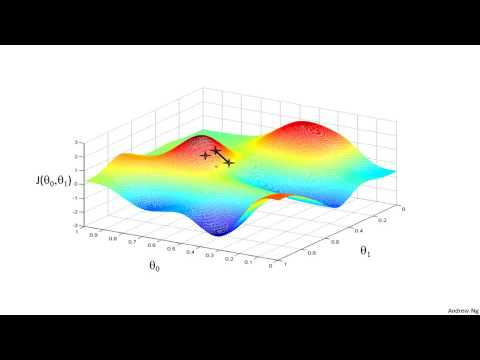

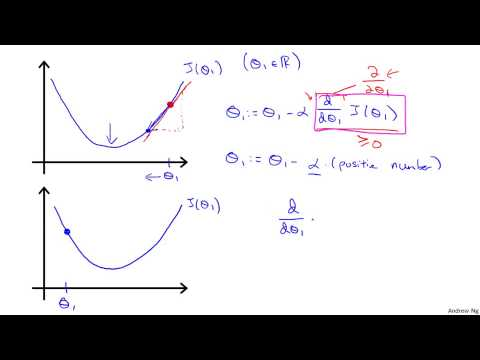

In [11]:
display(YouTubeVideo('P3K38HusyV4'))
display(YouTubeVideo('4SVqZaY55qo'))

### The cost function [1 pt]

*Gradient Descent* works exactly the same for more complex models like *Logistic Regression* or *Neural Networks*, as long as there is some function to compute the output and a cost function to optimize. The function for the classification error is defined as:

$$J(\Theta) = - \sum_{i=1}^M \sum_{k=1}^K Y^i_k log(H_\Theta(X^i)_k) + (1 - Y^i_k) log(1 - H_\Theta(X^i)_k)$$

which is the sum of the classification error for all $M$ training samples and all $K$ different outputs, when comparing the current output of the network $H_\Theta(X^i)_k$ to the target output $Y^i_k$. The video on the topic, if you want a more detailed breakdown, can be found here (note you may ignore the regularization term covered there):

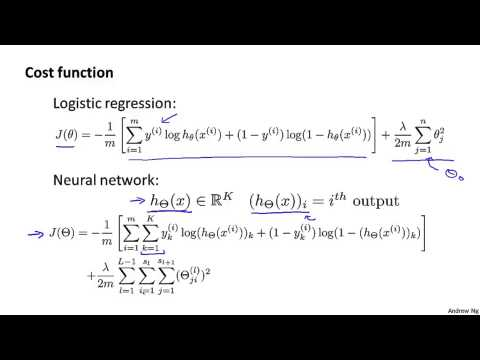

In [12]:
YouTubeVideo('18X68kLAfKY')

Write the function `cost_function`, which takes a matrix $A = H_\Theta(X)$ with the network activations at the output layer (rows are outputs for different training samples, columns are the different output nodes) and a matrix $Y$ of the same dimensions containing the training targets, and computes the total classification error.


In [13]:
def cost_function(A, Y):
    # A: final activation values
    # Y: training labels (supervision signal)
    # return: cost function shown above
    ### YOUR SOLUTION HERE
    return -np.sum(np.sum(Y * np.log(A) + (1 - Y) * np.log(1 - A), axis=1))
    
assert np.allclose(cost_function(np.array([[.1,.9],[.9,.1]]), np.array([[0,1],[1,0]])), 0.4214420626313051)

### Delta Terms [1 pt] 

Now we need take the partial derivatives of this cost function for each of the $\Theta$ parameters of our network, so we can start changing them to minimize the cost function. These gradients will be computed in 2 separate steps. First we define a term $\delta$ that contains the partial derivatives of the cost function with respect to the nodes input

$$\delta^j_i = \frac{\partial J}{\partial Z^j_i}$$

which is defined for each $i^{th}$ node in each $j^{th}$ layer. Computing this term separately will make the complete multilayer version much easier to write. For an output layer, i.e. when $j$ is the last layer in the network, the delta term is defined as:

$$\delta^j_i = A^j_i - Y_i$$

Note that, as before, this is again an equation which is defined for a **single sample** of input values and output values, i.e. the indices *do not* relate to the different training samples, only the node location in the network. So, $Y_i$ is just the $i^{th}$ target output (in the case of multi-class classification) for a single sample and the equation will compute a single $\delta$ value for $i^{th}$ node in the $j^{th}$ layer. If this process would be again repeated for each of the training samples, $\delta^j_i$ would be an array of values, each row corresponding to $\delta^j_i$ for one of the samples. 

Write the function `output_delta` which takes a complete matrix $A^j$ with all the network activations at layer $j$ (rows are outputs for different training samples, column are the different output nodes) and a matrix $Y$ (the same dimensions) containing the training targets, and computes the $\delta^j$ terms at the output layer for every sample. This should be a matrix of the same dimensions, with a separate $\delta$ term for each training sample, for every output node.


In [14]:
from numpy import float64
from jax import grad

def output_delta(A_j, Y):
    # A_j: Activation values
    # Y: training labels
    # return: derivative of cost w.r.t. final sigmoid input
    ### YOUR SOLUTION HERE
    return A_j - Y

assert np.allclose(output_delta(np.array([[0,1],[0,1]]), np.array([[0,1],[1,0]])), np.array([[0,0], [-1, 1]]))

### Computing the weight updates [1 pt]

With these $\delta$ terms computed, we can now compute the derivates with respect to the $\Theta$ parameters of the network

$$\frac{\partial J}{\partial \Theta_{ki}^j} = \sum_{d=1}^M (\delta^{j+1}_k)^{d}(A^j_i)^d$$

This is where all the different values for $\delta^{j+1}_k$ and $A^j_i$ for each sample are combined into a single gradient value for $\Theta_{ki}^j$. The sum here is over $d=1$ to $M$ (assuming there are $M$ different training samples) and $(\delta^{j+1}_k)^{d}$ and $(A^j_i)^d$ are the delta values and node activations for the $d^{th}$ training sample respectively.

Summing these values over all $M$ training samples will result in the overall gradient on the cost function for $\Theta_{ki}^j$, meaning this will be *Batch Gradient Descent*. The actual update to the weights is then just the standard *Gradient Descent* rule:

$$\Theta^j_{ki} = \Theta^j_{ki} - \alpha\frac{\partial J}{\partial \Theta_{ki}^j}$$

Write the function `weight_update`, which should compute these values for the weights of 1 layer, i.e. a matrix $\Theta^j$. It should return the new value for $\Theta^j$, given the old matrix $\Theta^j$, the activations matrix $A^j$ in at the layer $j$ (again, rows for different training samples, column are the different nodes in the layer), the $\delta^{j+1}$ matrix for the next layer $j+1$, called `Delta_next` and the learning rate $\alpha$, called `rate`.


In [15]:
def weight_update(A_j, Delta_next, Theta_j, rate):
    # A_j: activation values
    # Delta_next: preceding derivatives
    # Theta_j: Current param values
    # rate: learning rate (a.k.a. step size)
    ### YOUR SOLUTION HERE
    gradient = Delta_next.T @ A_j
    return Theta_j - rate * gradient

assert np.allclose(weight_update(np.array([[0,1],[0,1]]), np.array([[0,1],[1,0]]), np.array([[0,1],[1,0]]), 1.0), np.array([[0, 0], [1, -1]]))

In the case of a *Neural Network* with just 1 layer, this `weight_update` function will compute all the updated weights in a single step. Here `A_j` would refer to $A^0$, i.e. the activations at the input layer, and `Delta_next` would be the $\delta$ terms for the output layer.

### Training the single layer network [2 pts]

Now, given some training data, we just repeatedly compute the network outputs for each of the training inputs, then compute the deltas based on the training outputs, and finally update the weights. For every step of this repeated  computation, the weights should fit the training data slightly better and classification error on the training set should slowly decrease to a minimum. At that point the network should be able to reproduce the training outputs with an as low as possible error.

Write the function `one_layer_training`, which takes a data set consisting of matrices `X` and `Y`, and a list of the parameters `Theta`.  As there is just one layer in this case, `Theta` will just be a list of one element: `Theta = [Theta_0]`.  Additionally, the function takes 2 optional parameters; `iters` to indicate the number of iterations gradient descent should be repeated for, and `rate` to specify the learning rate that should be used for the updates. The function should then perform *Gradient Descent* on this data set, and store the value of the cost function at every step. 

Remember the steps required.

Repeat `iter` times:
   1. Compute the model output and any intermediate activations with `forward_prop`
   2. Get the $\delta$ terms for the output layer with `output_delta`
   3. Update $\Theta_0$ through `weight_update`
   4. Compute the cost for the current param values (to track the training progress)

At the end the function should plot a graph showing the error decreasing (on the y-axis, the x-axis is just a count of the iterations).  The function should return the parameters (also as a list).

In [16]:
import matplotlib.pyplot as plt

def one_layer_training(X, Y, Thetas, iters=250, rate=0.9):
    # (X, Y): features and labels
    # Thetas: list of weight matrices
    # iters: number of training updates / descent steps
    # rate: learning rate / step size
    # return: plot cost per iteration and return final param values (as a list)
    
    cost_per_iter = []
    ### YOUR SOLUTION HERE
    for i in range(iters):
        # forward prop
        A = forward_prop(X, Thetas)
        # compute update
        deltas = []
        for j in range(len(A)):
            deltas.append(output_delta(A[j], Y))

        for j in range(len(A) - 1):
            Thetas[j] = weight_update(A[j], deltas[j + 1], Thetas[j], rate)
        # track cost
        cost_per_iter.append(cost_function(A[-1], Y))
        
    plt.figure(figsize=(7,5))
    plt.plot([x+1 for x in range(iters)], cost_per_iter, "-b")
    plt.xlabel("Training Iterations", fontsize=18)
    plt.ylabel("Cost Function", fontsize=18)
    plt.show()
    
    return Thetas

### Learning boolean functions [1 pt]

Lets now try and learn some boolean functions using our single layer network, to test if training procedure works. Some boolean functions might be harder to learn than others, so it will be interesting to see what the network can and can't learn. Watch this video on the classic XOR problem.

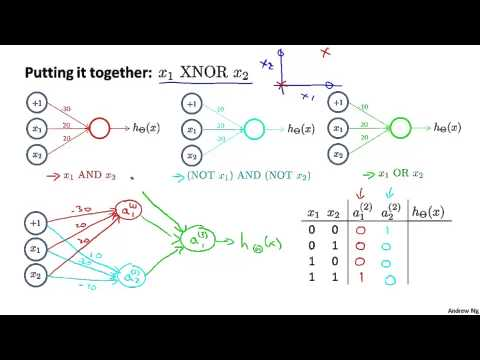

In [17]:
YouTubeVideo('QZqmNpEyiKI')

Below I've already defined the data for these boolean function problems.  You should train the one-layer network / perceptron on these data sets using your function above.  Be sure to use `n_layer_init(layer_sizes)` to get the initial parameters. I've also provided printing functions to show the labels and model outputs for visual comparison.

___AND Task___


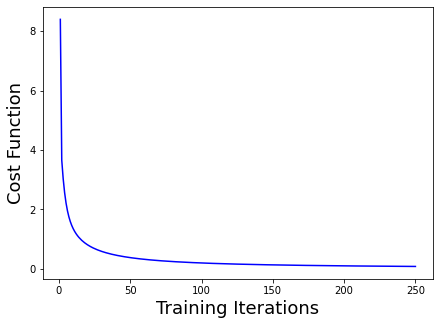

True Labels: 0.00, 1.00, 0.00, 0.00
Output Values: 0.00, 0.97, 0.02, 0.02

___OR Task___


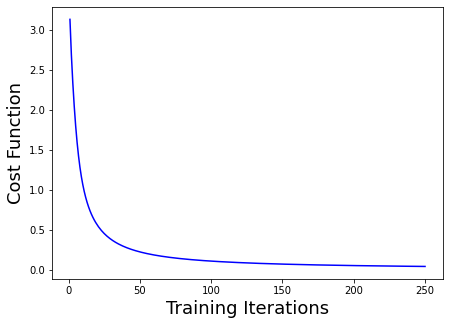

True Labels: 0.00, 1.00, 1.00, 1.00
Output Values: 0.02, 1.00, 0.99, 0.99

___XOR Task___


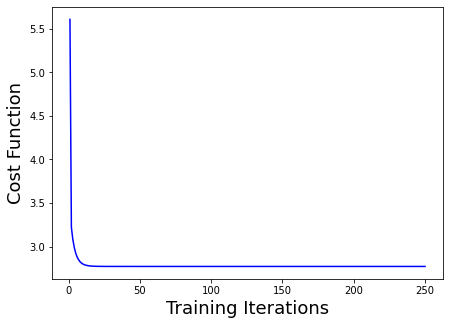

True Labels: 0.00, 0.00, 1.00, 1.00
Output Values: 0.50, 0.50, 0.50, 0.50


In [29]:
# Data for boolean functions
X = np.array([[0, 0], [1, 1], [0, 1], [1, 0]])
Y_AND = np.array([0, 1, 0, 0])[np.newaxis].T
Y_OR = np.array([0, 1, 1, 1])[np.newaxis].T
Y_XOR = np.array([0, 0, 1, 1])[np.newaxis].T

print("___AND Task___")
### YOUR SOLUTION HERE
layers_sizes = np.array([2, 1])
Thetas = n_layer_init(layers_sizes)
Thetas_final = one_layer_training(X, Y_AND, Thetas)
print('True Labels: %.2f, %.2f, %.2f, %.2f' %tuple(Y_AND[:,0].tolist()))
print('Output Values: %.2f, %.2f, %.2f, %.2f' %tuple(forward_prop(X, Thetas_final)[-1][:,0].tolist()))
      
print("\n___OR Task___")
### YOUR SOLUTION HERE
Thetas = n_layer_init(layers_sizes)
Thetas_final = one_layer_training(X, Y_OR, Thetas)
print('True Labels: %.2f, %.2f, %.2f, %.2f' %tuple(Y_OR[:,0].tolist()))
print('Output Values: %.2f, %.2f, %.2f, %.2f' %tuple(forward_prop(X, Thetas_final)[-1][:,0].tolist()))

print("\n___XOR Task___")
### YOUR SOLUTION HERE
Thetas = n_layer_init(layers_sizes)
Thetas_final = one_layer_training(X, Y_XOR, Thetas)
print('True Labels: %.2f, %.2f, %.2f, %.2f' %tuple(Y_XOR[:,0].tolist()))
print('Output Values: %.2f, %.2f, %.2f, %.2f' %tuple(forward_prop(X, Thetas_final)[-1][:,0].tolist()))

For the XOR data set, you should observe that the neural net fails to make the correct predictions.  This is the infamous [XOR problem](https://en.wikipedia.org/wiki/Perceptrons_(book)#The_XOR_affair) that may have contributed to the [AI Winter](https://en.wikipedia.org/wiki/AI_winter#The_abandonment_of_connectionism_in_1969) (whether it was real or percieved).  Next we will fix this limitation by adding a hidden layer.  

## Backpropagation [1 pt]

Until now we have only been training single layer networks, where the gradient was easily computed using the error at the output nodes. The *Backpropagation* algorithm extends this by also computing error terms at the hidden nodes and thus being able to update multilayer network weights in the direction of the gradient too.

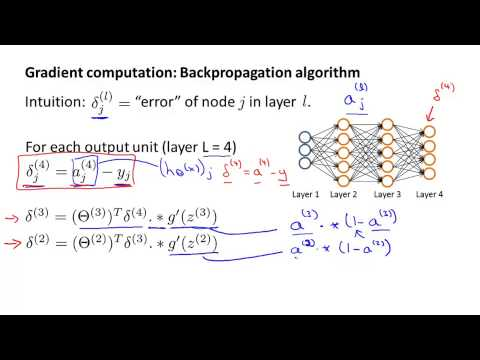

In [19]:
YouTubeVideo('SvAEX5taVKk')

Most of the functions you already wrote are still useful in the complete *Backpropagation* algorithm, the only real change is that there is now a delta term for hidden nodes too.

$$\delta^j_i = (1 - A^j_i)A^j_i \sum_k \delta^{j+1}_k\Theta^j_{ki} $$

These deltas take the deltas at the next layer and propagate them backwards, which is where the algorithm gets its name. The deltas for the output layer and the gradient descent update of the weights remain exactly the same as for the single layer network.

Once the deltas at the output layer are computed based on the difference between the computed outputs and the target outputs, we can compute deltas for the layer before it, carrying part of the error to the previous layer. Then we can use those det ltas to compute the deltas for the layer before that, and so on, all the way to the first layer of the network. These delta values for the hidden nodes can be used to compute the updates for weights in exactly the same way as for the output nodes.

Write the function `hidden_delta`, which computes the matrix of $\delta$ values for 1 hidden layer, where each row corresponds to the deltas for a different training sample and the columns corresponds to each of the nodes in that hidden layer. It should take as input the activations at that layer $A^j$, the $delta$ values for the next layer and the matrix of weights connecting them, $\Theta^j$.

In [20]:
def hidden_delta(A_j, Delta_next, Theta_j):
    # A_j: Activation values
    # Delta_next: preceding derivative
    # return: derivative of hidden layer w.r.t. the activations
    ### YOUR SOLUTION HERE
    return (1 - A_j) * A_j * (Delta_next @ Theta_j)

assert np.allclose(hidden_delta(np.array([[1,.9],[0.8,.9]]), np.array([[0,1],[.9,0.9]]), np.array([[1,1],[.2,0.9]])), np.array([[0.,0.081],[0.1728,0.1539]]))

### Training 2 layers [3 pts]

Now all that remains is to combine these functions into a multilayer network. These videos should help get an overview of the pieces you need:

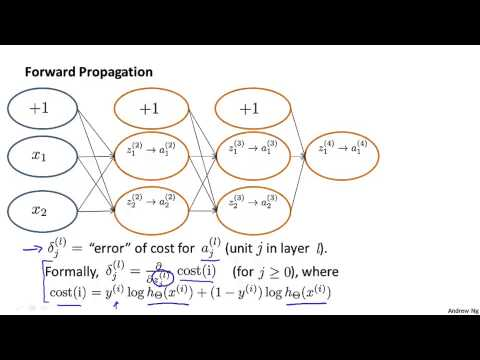

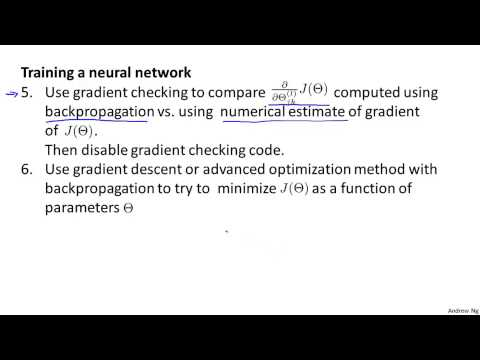

In [21]:
display(YouTubeVideo('q1bQDyV6lsg'))
display(YouTubeVideo('T7-ZsYlFH4M'))

Write the function `two_layer_training`, which should work exactly like the function `one_layer_training`, except now the parameter list has two elements, both of which need updating. That is, `Thetas = [Theta_0, Theta_1]` where $\Theta^0$ should contain the weights connecting the input layer to the hidden layer and $\Theta^1$ should contain the weights connecting the hidden layer to the output layer. And again, we have the two optional parameters: `iters` to indicate the number of iterations gradient descent should be repeated for, and `rate` to specify the learning rate that should be used for the updates. The function should then perform *Gradient Descent* on this data set, and store the value of the cost function at every step. 

Remember the steps required:

Repeat `iter` times:
   1. Compute the model output and any intermediate activations with `forward_prop` 
   2. Get the $\delta$ terms for the layers with `output_delta` and `hidden_delta`; first take the $\delta$ of the output layer, then get the $\delta$ of the hidden layer.
   3. *Remove* a dimension from `hidden_delta`, as it corresponds to the bias dimension (and doesn't need backpropagated)
   3. Update $\Theta_1$ and $\Theta_0$  using `weight_update`

At the end the function should plot the cost function as it decreases with each iteration and return the computed values for $\Theta^0$ and $\Theta^1$ as a list (same as input format).

In [22]:
def two_layer_training(X, Y, Thetas, iters=500, rate=0.5):
    cost_per_iter = []
    ### YOUR SOLUTION HERE
    for i in range(iters):
        # compute hidden layers
        A = forward_prop(X, Thetas)
        output_delt = output_delta(A[-1], Y)
        hidden_delt = hidden_delta(A[1], output_delt, Thetas[1])
        hidden_delt = hidden_delt[:, 1:]
        # update Theta_1
        Thetas[1] = weight_update(A[1], output_delt, Thetas[1], rate)
        # update Theta_0
        Thetas[0] = weight_update(A[0], hidden_delt, Thetas[0], rate)
        # remove dimension corresponding to bias
        
        # track loss
        cost_per_iter.append(cost_function(A[-1], Y))

    plt.figure(figsize=(7,5))
    plt.plot([x+1 for x in range(iters)], cost_per_iter, "-b")
    plt.xlabel("Training Iterations", fontsize=18)
    plt.ylabel("Cost Function", fontsize=18)
    plt.show()
    
    return Thetas

### Revisiting the boolean functions  [1 pt]

Rerun the tests to learn the 3 boolean functions; *AND*, *OR* and *XOR*, but use 2 layer networks (2 inputs, 5 hidden nodes and 1 output node) this time. Plot the cost function for each problem and show the final computed output for each function.

__AND Task__


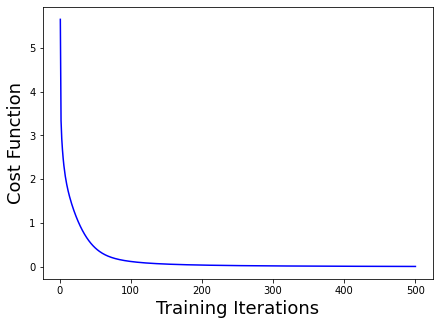

True Labels: 0.00, 1.00, 0.00, 0.00
Output Values: 0.00, 0.99, 0.00, 0.00

__OR Task__


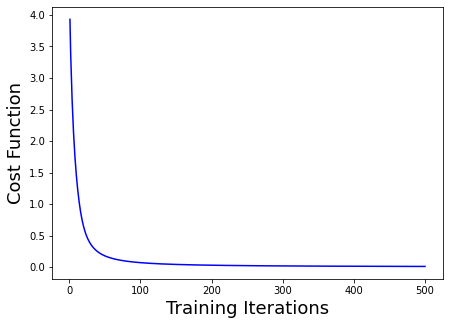

True Labels: 0.00, 1.00, 1.00, 1.00
Output Values: 0.00, 1.00, 1.00, 1.00

__XOR Task__


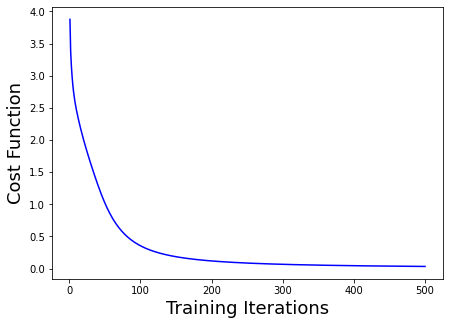

True Labels: 0.00, 0.00, 1.00, 1.00
Output Values: 0.01, 0.01, 1.00, 0.99


In [23]:
print("__AND Task__")
### YOUR SOLUTION HERE
layers_sizes = np.array([2, 5, 1])
Thetas = n_layer_init(layers_sizes)
Thetas_final = two_layer_training(X, Y_AND, Thetas)
print('True Labels: %.2f, %.2f, %.2f, %.2f' %tuple(Y_AND[:,0].tolist()))
print('Output Values: %.2f, %.2f, %.2f, %.2f' %tuple(forward_prop(X, Thetas_final)[-1][:,0].tolist()))

print("\n__OR Task__")
### YOUR SOLUTION HERE
layers_sizes = np.array([2, 5, 1])
Thetas = n_layer_init(layers_sizes)
Thetas_final = two_layer_training(X, Y_OR, Thetas)
print('True Labels: %.2f, %.2f, %.2f, %.2f' %tuple(Y_OR[:,0].tolist()))
print('Output Values: %.2f, %.2f, %.2f, %.2f' %tuple(forward_prop(X, Thetas_final)[-1][:,0].tolist()))

print("\n__XOR Task__")
### YOUR SOLUTION HERE
layers_sizes = np.array([2, 5, 1])
Thetas = n_layer_init(layers_sizes)
Thetas_final = two_layer_training(X, Y_XOR, Thetas)
print('True Labels: %.2f, %.2f, %.2f, %.2f' %tuple(Y_XOR[:,0].tolist()))
print('Output Values: %.2f, %.2f, %.2f, %.2f' %tuple(forward_prop(X, Thetas_final)[-1][:,0].tolist()))

You should observe that the network is now able to solve the XOR problem.

## Automatic Differentiation with Jax

Above, you had to calculate the derivatives the hard way: by hard-coding them yourself.  However, today there are a variety of software libraries that allow for *automatic differentiation*, or *auto-diff* for short.  We'll take a look at the library [Jax](https://github.com/google/jax).  It allows us to write functions in Numpy and get the derivatives with one extra function call.  That's why we imported Numpy above in a different way than usual.  Importing it from Jax also brings with it a host of back-end code that allows for automatic differentiation.  Consider the example below.

In [24]:
# Import the grad() function
# This is what calculates the derivatives for us
from jax import grad

# Define a simple test function
def test_function(x, w, a=5):
    return np.dot(x**a, w)

# For comparison with Jax's output, 
# we'll hard-code the test function's derivative
def my_derivative(x, w, a=5):
    # compute df/dx the hard way, by hand
    return a * x**(a-1) * w

# auto-diff magic!
# All you have to do is call grad(func_to_diff),
# passing in the function that you want to 
# differentiate (func_to_diff) as the argument.
# Jax will then compute the derivative w.r.t.
# the *first argument* of func_to_diff(x, y, z).
# So jax will return a function for d_func_to_diff/d_x:
jax_derivative = grad(test_function)

### test the code
x = np.array([.3, .4, .5, .6])
w = np.array([4, 4.7, 3.1, 2.6])

print("Hand-Coded Derivative:")
print(my_derivative(x, w))

print("\nJax Derivative:")
print(jax_derivative(x, w))

Hand-Coded Derivative:
[0.162      0.60160005 0.96875    1.6847999 ]

Jax Derivative:
[0.162      0.60160005 0.96875    1.6847999 ]


### Auto-differentiate cost function  [2 pt]

Now let's re-implement the two-layer training function the easy way, using Jax.  You have already defined almost everything that you need.  All that is left to do is to define a function `optimization_obj` that takes as input the parameters and the data, gets the prediction using `forward_prop`, and then returns the cost for the current parameter settings.  We will then pass this function to Jax's `grad(...)` function to get a function for the derivative.  Remember than the parameters must be the first input!  Also note that now we do not need those intermediate activations, so you really just need to use the last element in the list that `forward_prop` returns.  

In [25]:
def optimization_objective(Thetas, X, Y):
    # Thetas: list containing the NN's weight matrices.
    # X, Y: features and labels, respectively
    # return: cost function for the given data set and parameter values
    ### YOUR SOLUTION HERE
    prediction = forward_prop(X, Thetas)[-1]
    return cost_function(prediction, Y)

### YOUR SOLUTION HERE
objective_grad = grad(optimization_objective)

# Here's a test of your implementation
assert np.allclose(objective_grad([np.array([[1., 2., 3.]])], X, Y_AND)[0], np.array([[2.6631727 , 0.9501017 , 0.97953963]]))

### Reimplementing training function w/ Jax derivatives  [2 pts]

Now we need to implement one last training function.  This one will rely on Jax to compute all the derivatives.  I've defined the general structure for you already.

In [26]:
def jax_training(X, Y, Thetas, iters=500, rate=0.5):
    cost_per_iter = []
    for i in range(iters):
        ### YOUR SOLUTION HERE
    
        # Get the Theta gradients using Jax
        objective_grad = grad(optimization_objective)
        theta_gradients = objective_grad(Thetas, X, Y)
        # Loop through the gradients and make updates to Thetas
        for i in range(len(Thetas)):
            Thetas[i] -= rate * theta_gradients[i]
        # track cost function
        cost_per_iter.append(optimization_objective(Thetas, X, Y))
        
    # plot cost per iteration
    plt.figure(figsize=(7,5))
    plt.plot([x+1 for x in range(iters)], cost_per_iter, "-b")
    plt.xlabel("Training Iterations", fontsize=18)
    plt.ylabel("Cost Function", fontsize=18)
    plt.show()
    
    return Thetas

### Re-Revisiting the boolean functions  [1 pt]

Now run the training code using the Boolean function data once again.  Again use a NN with one hidden layer.  You should see similar results as before.

___AND Task___


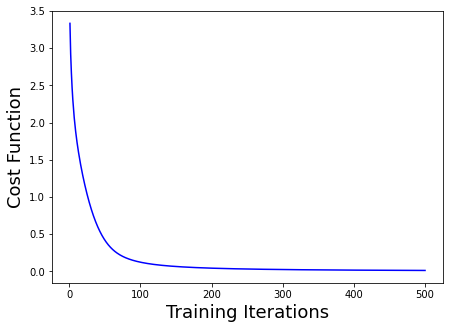

True Labels: 0.00, 1.00, 0.00, 0.00
Output Values: 0.00, 0.99, 0.00, 0.00

___OR Task___


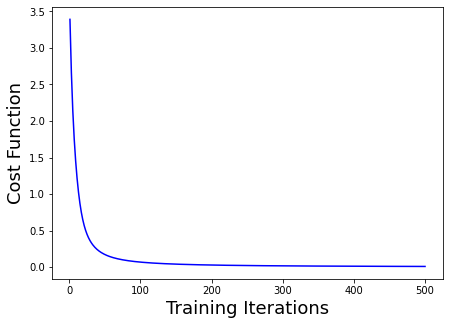

True Labels: 0.00, 1.00, 1.00, 1.00
Output Values: 0.00, 1.00, 1.00, 1.00

___XOR Task___


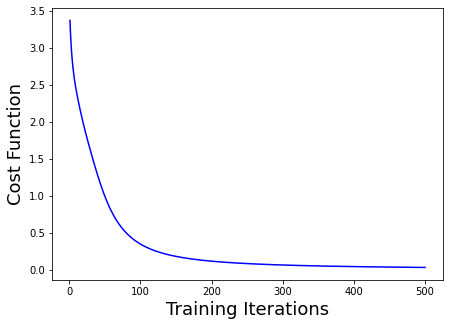

True Labels: 0.00, 0.00, 1.00, 1.00
Output Values: 0.01, 0.01, 1.00, 0.99


In [27]:
print("___AND Task___")
### YOUR SOLUTION HERE
Thetas = n_layer_init([2, 5, 1])
thetas_final = jax_training(X, Y_AND, Thetas)
print('True Labels: %.2f, %.2f, %.2f, %.2f' %tuple(Y_AND[:,0].tolist()))
print('Output Values: %.2f, %.2f, %.2f, %.2f' %tuple(forward_prop(X, thetas_final)[-1][:,0].tolist()))

print("\n___OR Task___")
### YOUR SOLUTION HERE
Thetas = n_layer_init([2, 5, 1])
thetas_final = jax_training(X, Y_OR, Thetas)
print('True Labels: %.2f, %.2f, %.2f, %.2f' %tuple(Y_OR[:,0].tolist()))
print('Output Values: %.2f, %.2f, %.2f, %.2f' %tuple(forward_prop(X, thetas_final)[-1][:,0].tolist()))

print("\n___XOR Task___")
### YOUR SOLUTION HERE
Thetas = n_layer_init([2, 5, 1])
thetas_final = jax_training(X, Y_XOR, Thetas)
print('True Labels: %.2f, %.2f, %.2f, %.2f' %tuple(Y_XOR[:,0].tolist()))
print('Output Values: %.2f, %.2f, %.2f, %.2f' %tuple(forward_prop(X, thetas_final)[-1][:,0].tolist()))

## Deep Neural Networks: 3+ Layers
Now with our Jax implementation, it is very easy to define and train neural networks with more than two layers.  In fact, we already have all the code in place!  

### Re-Re-Revisiting the boolean functions  [1 pt]
Try training a network with three hidden layers of three units each (5 total layers) below:

___AND Task___


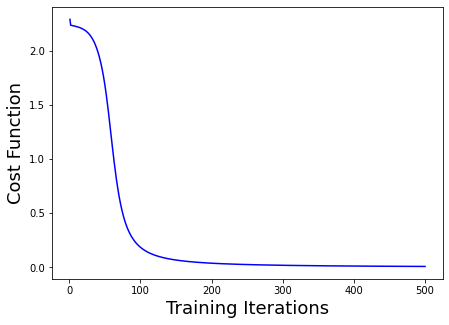

True Labels: 0.00, 1.00, 0.00, 0.00
Output Values: 0.00, 0.99, 0.00, 0.00

___OR Task___


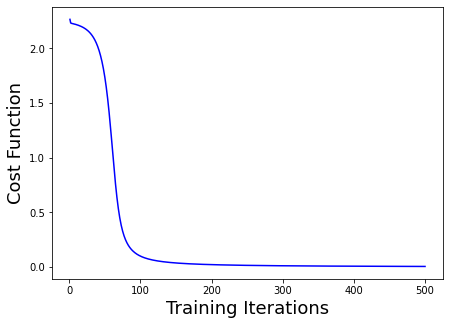

True Labels: 0.00, 1.00, 1.00, 1.00
Output Values: 0.00, 1.00, 1.00, 1.00

___XOR Task___


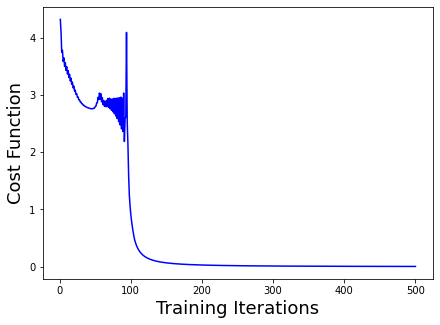

True Labels: 0.00, 0.00, 1.00, 1.00
Output Values: 0.00, 0.00, 1.00, 1.00


In [28]:
# Initialize net with 5 layers! :0
Thetas_init = n_layer_init([2, 3, 3, 3, 1])

print("___AND Task___")
### YOUR SOLUTION HERE
thetas_final = jax_training(X, Y_AND, Thetas_init)
print('True Labels: %.2f, %.2f, %.2f, %.2f' %tuple(Y_AND[:,0].tolist()))
print('Output Values: %.2f, %.2f, %.2f, %.2f' %tuple(forward_prop(X, thetas_final)[-1][:,0].tolist()))

Thetas_init = n_layer_init([2, 3, 3, 3, 1])
print("\n___OR Task___")
### YOUR SOLUTION HERE
thetas_final = jax_training(X, Y_OR, Thetas_init)
print('True Labels: %.2f, %.2f, %.2f, %.2f' %tuple(Y_OR[:,0].tolist()))
print('Output Values: %.2f, %.2f, %.2f, %.2f' %tuple(forward_prop(X, thetas_final)[-1][:,0].tolist()))

Thetas_init = n_layer_init([2, 3, 3, 3, 1])
print("\n___XOR Task___")
### YOUR SOLUTION HERE
thetas_final = jax_training(X, Y_XOR, Thetas_init, rate=1.2)
print('True Labels: %.2f, %.2f, %.2f, %.2f' %tuple(Y_XOR[:,0].tolist()))
print('Output Values: %.2f, %.2f, %.2f, %.2f' %tuple(forward_prop(X, thetas_final)[-1][:,0].tolist()))